In [2]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# NOTE: You will need to set AWS access keys for the MCP environment

In [6]:
%%time
client = boto3.client('logs', region_name='us-west-2')

query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "attribute"
| parse @message /:attribute \["(?<attribute>.+)"\]/
| stats count(*) as number_queries by attribute
| sort by number_queries desc
"""

print(query)
log_group = 'cmr-search-ops'
datetime_str = '05/18/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(10)
    logs_response = client.get_query_results(
        queryId=query_id
    )


fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "attribute"
| parse @message /:attribute \["(?<attribute>.+)"\]/
| stats count(*) as number_queries by attribute
| sort by number_queries desc

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for quer

In [7]:
# Save the results so we don't have to re-run the query
filename = f"attribute_search-{query_id}.json"
with open(filename, "w+") as f:
    f.write(json.dumps(logs_response))
    f.close()

In [8]:
data = json.loads(open(filename).read())
data

{'results': [[{'field': 'attribute',
    'value': 'string,Site Name,Lope National Park Gabon'},
   {'field': 'number_queries', 'value': '154'}],
  [{'field': 'attribute',
    'value': 'string,Site Name,Mondah Forest Gabon" "string,Data Format,ASCII'},
   {'field': 'number_queries', 'value': '76'}],
  [{'field': 'attribute', 'value': 'string,Site Name,Mondah Forest Gabon'},
   {'field': 'number_queries', 'value': '72'}],
  [{'field': 'attribute',
    'value': 'string,Site Name,Lope National Park Gabon" "float,Track Number,001'},
   {'field': 'number_queries', 'value': '8'}],
  [{'field': 'attribute', 'value': 'float,Track Number,001'},
   {'field': 'number_queries', 'value': '8'}],
  [{'field': 'attribute', 'value': 'string,Site Name,lope'},
   {'field': 'number_queries', 'value': '7'}],
  [{'field': 'attribute',
    'value': 'float,Track Number,001" "string,Polarization,HH'},
   {'field': 'number_queries', 'value': '7'}],
  [{'field': 'attribute',
    'value': 'string,Site Name,Mondah 

In [9]:
restructured_data = []
for result in logs_response['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data

[{'attribute': 'string,Site Name,Lope National Park Gabon',
  'number_queries': '154'},
 {'attribute': 'string,Site Name,Mondah Forest Gabon" "string,Data Format,ASCII',
  'number_queries': '76'},
 {'attribute': 'string,Site Name,Mondah Forest Gabon', 'number_queries': '72'},
 {'attribute': 'string,Site Name,Lope National Park Gabon" "float,Track Number,001',
  'number_queries': '8'},
 {'attribute': 'float,Track Number,001', 'number_queries': '8'},
 {'attribute': 'string,Site Name,lope', 'number_queries': '7'},
 {'attribute': 'float,Track Number,001" "string,Polarization,HH',
  'number_queries': '7'},
 {'attribute': 'string,Site Name,Mondah Forest Gabon" "string,Data Format,GeoTIFF',
  'number_queries': '4'},
 {'attribute': 'string,Acquisition Type,Satellite Lidar',
  'number_queries': '4'},
 {'attribute': 'Geolocated', 'number_queries': '2'},
 {'number_queries': '2'},
 {'attribute': 'string,Site Name,Lope National Park Gabon" "string,Data Format,rdr',
  'number_queries': '2'},
 {'attr

In [26]:
count_data = {}

for result in restructured_data:
    if 'attribute' in result:
        attribute_keyname = ','.join(result['attribute'].split(",")[-2:])
        count_data[attribute_keyname] = int(result['number_queries'])

count_data = {k: v for k, v in sorted(count_data.items(), key=lambda item: item[1], reverse=True)}

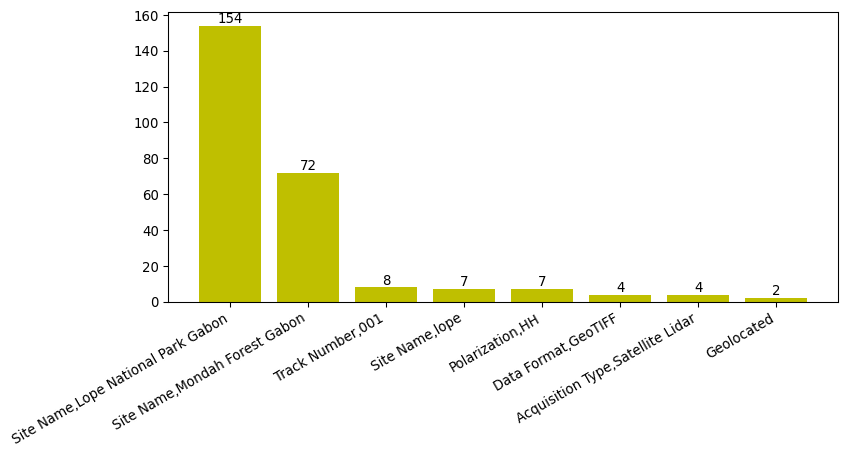

In [27]:
limit = 8
attributes = list(count_data.keys())[0:limit]
number_queries = list(count_data.values())[0:limit]

plt.figure(figsize=(9, 4), dpi=96)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va= 'bottom')

plt.bar(attributes, number_queries, color='y')
addlabels(attributes, number_queries)
plt.xticks(rotation=30, ha='right')
plt.show()